<h1 align='center'>Neural Style Transfer with Color Transfer

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
    tensor = tensor[0]
    return Image.fromarray(tensor)

In [3]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [4]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

In [5]:
c_image= load_img("japanese_garden.jpg")
s_image = load_img("picasso_selfportrait.jpg")

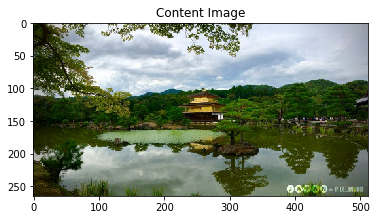

In [6]:
imshow(c_image,'Content Image')

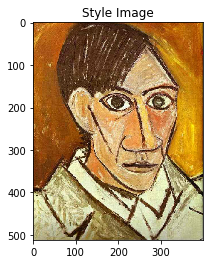

In [7]:
imshow(s_image,'Style Image')

<h3> Converting the style image to the color of the original image to preserve color of the content image

In [8]:
from color_transfer import color_transfer #https://github.com/jrosebr1/color_transfer/blob/master/example.py
import cv2

In [9]:
st_image = color_transfer(cv2.imread('./japanese_garden.jpg'),cv2.imread('./picasso_selfportrait.jpg'))

In [10]:
cv2.imwrite('styleimg.jpg',st_image)

True

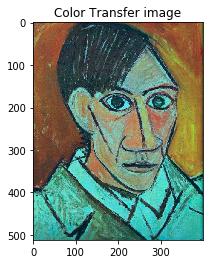

In [11]:
s_image = load_img('styleimg.jpg')
imshow(s_image, 'Color Transfer image')

<h3>Taking a look at the architecture of the VGG19 CNN

In [12]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

<h3>Choosing the layers for content and style aspects of the generated image

<p>I have chosen the last few layers of VGG19 for the content image as in my testing it showed that it detects the pagoda best which is the subject of the content image.<br>Whereas, I have chosen the shallow layers for the style image as piccasso's potrait has many definitive lines which are features detected earlier in the neural network. I picked a few deeper layers to add in some colors as the deeper layers have a chance of detecting more complex features like color patterns.

In [13]:
content_layer = ['block4_conv4','block5_conv2','block5_conv3','block5_conv4']
style_layer = ['block2_conv1','block2_conv2','block3_conv1']

In [14]:
def model_init(layers):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
 
  outputs = [vgg.get_layer(name).output for name in layers]
  model = tf.keras.Model([vgg.input],outputs)
  return model


In [15]:
style_extractor = model_init(style_layer)
style_outputs = style_extractor(s_image*255)

<h3>Defining the Gram matrix

<p>I have chosen to take an un-weighted covariance matrix as the gram matrix

In [16]:
def gram_matrix(A):
  return tf.linalg.einsum('bijc,bijd->bcd', A, A)


In [17]:
class DefineModel(tf.keras.models.Model):
  def __init__(self,style_layers,content_layer):
    super(DefineModel, self).__init__()
    self.vgg =  model_init(style_layers + content_layer)
    self.style_layers = style_layers
    self.content_layers = content_layer
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}
    
    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [18]:
extractor = DefineModel(style_layer, content_layer)

results = extractor(tf.constant(c_image))

In [19]:
style_targets = extractor(s_image)['style']
content_targets = extractor(c_image)['content']

In [20]:
generated_image = tf.Variable(c_image)

In [21]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1) #LR changed - paper by Khandelwal, changed back to 0.02 as lr > 0.02 distorts image

<h3>Defining the cost function which will be reduced

<p>The cost function is of the form<br><br><br>
    J = content_weight*content_cost + style_weight*style_cost + variation_weight*variation_loss

In [22]:
#Defining Alpha and Beta for weighting costs
style_weight=1e-6 #alpha
content_weight=10000 #beta
variation_weight = 300


def cost(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight 

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight
    loss = style_loss + content_loss
    return loss


In [23]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = cost(outputs)
    loss += variation_weight * tf.reduce_sum(tf.image.total_variation(image))

  grad = tape.gradient(loss, image) #Finds the derivative d(loss)/diamge
  opt.apply_gradients([(grad, image)]) #Updated the image with the gradients

10Number of epochs done.
20Number of epochs done.
50Number of epochs done.
100Number of epochs done.
250Number of epochs done.
500Number of epochs done.
1000Number of epochs done.
1500Number of epochs done.
2500Number of epochs done.
Time taken: 4.750297248363495


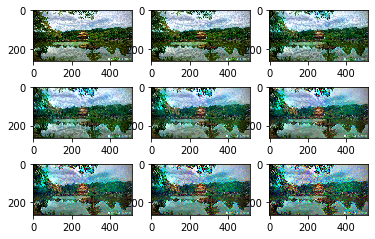

In [24]:
epoch_dict={1:10,2:20,3:50,4:100,5:250,6:500,7:1000,8:1500,9:2500}
import time
style_weight=10
content_weight=1e15
start = time.time()
generated_image=tf.Variable(c_image)
key = 1
for i in range(1,2501):
    train_step(generated_image)
    if(i in epoch_dict.values()):
        print(str(i)+"Number of epochs done.")
        plt.subplot(3,3,(key))
        key +=1
        imshow(tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0))
        tensor_to_image(tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)).save('Epoch '+str(key)+'.jpg')
print("Time taken: "+str((time.time()-start)/60))

<h3>Viewing all the images with greater clarity

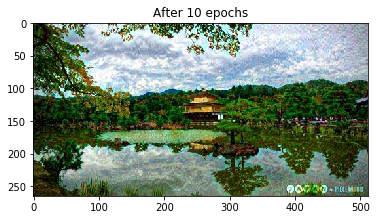

In [26]:
imshow(load_img('Epoch 2.jpg'),"After 10 epochs")

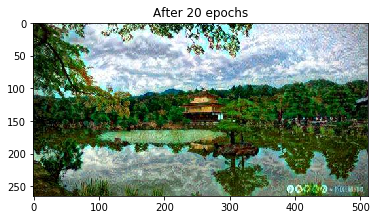

In [27]:
imshow(load_img('Epoch 3.jpg'),"After 20 epochs")

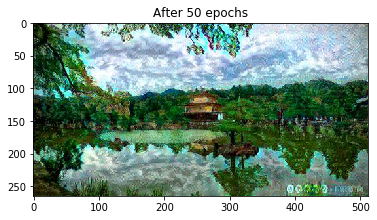

In [28]:
imshow(load_img('Epoch 4.jpg'),"After 50 epochs")

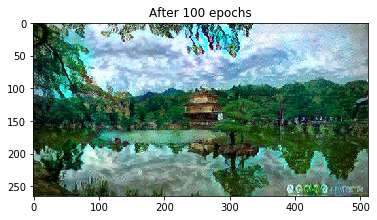

In [29]:
imshow(load_img('Epoch 5.jpg'),"After 100 epochs")

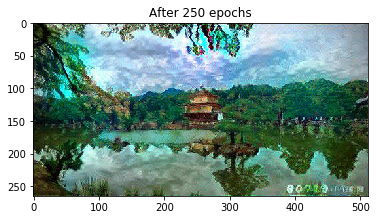

In [30]:
imshow(load_img('Epoch 6.jpg'),"After 250 epochs")

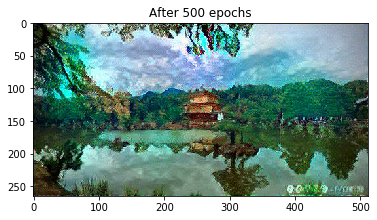

In [31]:
imshow(load_img('Epoch 7.jpg'),"After 500 epochs")

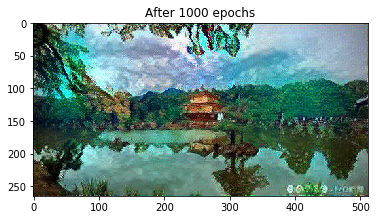

In [32]:
imshow(load_img('Epoch 8.jpg'),"After 1000 epochs")

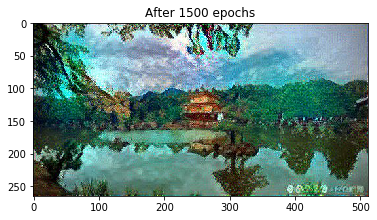

In [33]:
imshow(load_img('Epoch 9.jpg'),"After 1500 epochs")

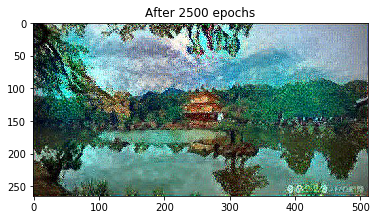

In [34]:
imshow(load_img('Epoch 10.jpg'),"After 2500 epochs")

<p>There are very few changes that can be observed as the number of epochs are increased so we can say that optimization has converged to a minima, which may or may not be a local one. 

<h3>Testing with Google Hub API

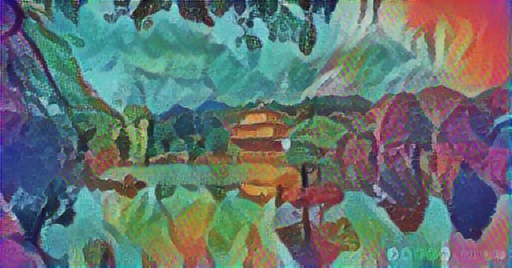

In [35]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(c_image), tf.constant(s_image))[0]
tensor_to_image(stylized_image)

<p>The google api for neural style transfer tends to add extra colors which in my opinion take away the style from picasso's painting. I believe that the google api has taken deeper style layers and is overfitting the model towards the style image which takes away most of the detail from the content image. 

<h3>Conclusion

<p>The code here has been greatly influenced by Tensorflow's tutorial on Neural Art Style transfer, the link to which will be provided in the References Section below. Another great influencing factor, this time towards the intuition behind the modifications and tweaks was the course on Convolutional Neural Networks by Deeplearning.ai on Coursera. </p>
<p>Key Observation points I have made:
    <ul>
        <li>The weights added to each individual cost component can be tweaked to achieve a more biased image</li>
        <li>The normalization terms for calculating individual cost component can vary and can even be zero, as long as the weights are modified</li>
        <li>The number of epochs required to reach convergence for the model I have picked is around 2000.</li>
        <li>Tensorflow 2.1.0 does not have good support for GPU at the moment.</li>
     </ul>
</p>

<h3>References

<ol>
    <li>Konar, Jinia et al. “Comparison of Various Learning Rate Scheduling Techniques on Convolutional Neural Network.” 2020 IEEE International Students' Conference on Electrical,Electronics and Computer Science (SCEECS) (2020): 1-5.<a>https://www.semanticscholar.org/paper/Comparison-of-Various-Learning-Rate-Scheduling-on-Konar-Khandelwal/2a70c38db475a610fc44eb0705b6b339235e70a6s</a></li>
    <li>Khandelwal, Siddhant et al. “Analysis of Hyperparameter Tuning in Neural Style Transfer.” 2018 Fifth International Conference on Parallel, Distributed and Grid Computing (PDGC) (2018): 36-41.<a>https://www.semanticscholar.org/paper/Analysis-of-Hyperparameter-Tuning-in-Neural-Style-Khandelwal-Rana/9d0242b2221a80ba15a629b89d4597f92bc5c2a1#related-papers</a></li>
    <li>CNNs - https://www.coursera.org/learn/convolutional-neural-networks?specialization=deep-learning</a></li>
    <li>Inuition towards Neural Style Transfer - <a>https://www.youtube.com/watch?v=R39tWYYKNcI&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=38&t=22s</a></li>
    <li>A Neural Algorithm of Artistic Style -Leon A. Gatys, Alexander S. Ecker, Matthias Bethge -<a>https://arxiv.org/abs/1508.06576</a></li>
    <li>Preserving Color in Neural Artistic Style Transfer - Leon A. Gatys, Matthias Bethge, Aaron Hertzmann -<a>https://arxiv.org/pdf/1606.05897.pdf</a></li>
</ol>